In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def plot_matrix(x, y, group, fmt='.', **kwargs):
    """
    Given two d-dimensional datasets of n points,
    makes a figure containing d x d plots, where the (i, j) plot
    plots the ith dimension against the jth dimension.
    """

    x = np.asarray(x)
    y = np.asarray(y)
    group = np.squeeze(np.asarray(group))
    n, p = x.shape
    n_, q = y.shape
    n__, = group.shape
    assert n == n_ == n__
    groups = sorted(set(group))
    if isinstance(fmt, str):
        fmt = {k: fmt for k in groups}
    fig, axes = plt.subplots(p, q, squeeze=False, **kwargs)
    for i, axrow in enumerate(axes):
        for j, ax in enumerate(axrow):
            for g in groups:
                ax.plot(x[group == g, i], y[group == g, j], fmt[g])
            if len(axes) > 2:
                ax.locator_params(tight=True, nbins=4)

def plot_groups(x, group, fmt='.', **kwargs):
    """
    Helper function for plotting a 2-dimensional dataset with groups
    using plot_matrix.
    """
    n, d = x.shape
    assert d == 2
    x1 = x[:, 0].reshape(n, 1)
    x2 = x[:, 1].reshape(n, 1)
    plot_matrix(x1, x2, group, fmt, **kwargs)

In [3]:
import sklearn.datasets
iris = sklearn.datasets.load_iris()
data = iris['data']
labels = iris['target']


In [70]:
from scipy.stats import multivariate_normal
def pdf(points, mean, cov, prior):
    points, mean, cov = np.asarray(points), np.asarray(mean), np.asarray(cov)
    prior = np.asarray(prior)
    n, d = points.shape
    k, d_1 = mean.shape
    k_2, d_2, d_3 = cov.shape
    k_3, = prior.shape
    assert d == d_1 == d_2 == d_3
    assert k == k_2 == k_3, "%s %s %s should be equal" % (k, k_2, k_3)

    # Compute probabilities
    prob = []
    for i in range(k):
        if prior[i] < 1 / k ** 3:
            prob.append(np.zeros(n))
        else:
#            print("pdf mean ",mean[i])
#            print("pdf cov ",cov[i])
            prob.append(
                prior[i] *
                multivariate_normal.pdf(
                    mean=mean[i], cov=cov[i], x=points,allow_singular=True))
    prob = np.transpose(prob)  # n x k
    # Normalize cluster probabilities of each point
    prob = prob / np.sum(prob, axis=1, keepdims=True)  # n x k

    assert prob.shape == (n, k)
    assert np.allclose(prob.sum(axis=1), 1)
    return prob

In [5]:
def most_likely(points, mean, cov, prior):
    prob = pdf(points, mean, cov, prior)
    return np.argmax(prob, axis=1)

In [81]:
def em(points, k, epsilon, mean=None):
    points = np.asarray(points)
    n, d = points.shape

    # Initialize and validate mean
    if mean is None:
        # Randomly pick k points
        maximum = np.amax(points, axis = 0)
        minimum = np.amin(points, axis = 0)
        mean = np.zeros((k,d))
        for i in range(k):
            for j in range(d):
                mean[i,j] = np.random.uniform(minimum[j], maximum[j])

    # Validate input
    mean = np.asarray(mean)
    k_, d_ = mean.shape
    assert k == k_
    assert d == d_

    # Initialize cov, prior
    cov = np.array([np.eye(d) for x in range(k)])
    prior = np.array([1/k for x in range(k)])

    tired = False
    old_mean = np.zeros_like(mean)
    while not tired:
        old_mean[:] = mean

        # Expectation step
 #       print("--------------------------------")
 #       print("Emean ",mean)
 #       print("Ecov ",cov)
 #       print("Eprior ",prior)
        weights=pdf(points, mean, cov, prior)
 #       print ("weights ",weights)
        # Maximization step
        weights_sum=np.sum(weights,axis=0)
 #       print("sum",weights_sum)
        for i in range(k):
            res=weights[:,i].reshape(n,1)*points
            mean[i]=np.sum(res,axis=0)/weights_sum[i]
            new_cov=np.zeros([d,d])
            for j in range(n):
                new_cov+=weights[j,i]*np.outer(points[j]-mean[i],points[j]-mean[i])
            cov[i]=new_cov/weights_sum[i]
        prior[:]=weights_sum/n    
                    

        # Finish condition
        dist = np.sqrt(((mean - old_mean) ** 2).sum(axis=1))
        tired = np.all(dist < epsilon)
    print("HURTIG")
    # Validate output
    assert mean.shape == (k, d)
    assert cov.shape == (k, d, d)
    assert prior.shape == (k,)
    return mean, cov, prior

In [76]:
def em(points, k, epsilon, mean=None):
    points = np.asarray(points)
    n, d = points.shape

    # Initialize and validate mean
    if mean is None:
        # Randomly pick k points
        maximum = np.amax(points, axis = 0)
        minimum = np.amin(points, axis = 0)
        mean = np.zeros((k,d))
        for i in range(k):
            for j in range(d):
                mean[i,j] = np.random.uniform(minimum[j], maximum[j])

    # Validate input
    mean = np.asarray(mean)
    k_, d_ = mean.shape
    assert k == k_
    assert d == d_

    # Initialize cov, prior
    cov = np.array([np.eye(d) for x in range(k)])
    prior = np.array([1/k for x in range(k)])

    tired = False
    old_mean = np.zeros_like(mean)
    while not tired:
        old_mean[:] = mean

        # Expectation step
 #       print("--------------------------------")
 #       print("Emean ",mean)
 #       print("Ecov ",cov)
 #       print("Eprior ",prior)
        weights=pdf(points, mean, cov, prior)
 #       print ("weights ",weights)
        # Maximization step
        weights_sum=np.sum(weights,axis=0)
 #       print("sum",weights_sum)
        for i in range(k):
            weight_sum_s=0
            for j in range(n):
                weight_sum_s+=weights[j,i]
            mean_sum=np.zeros(d)
 #           print(mean_sum)
            for j in range(n):
                mean_sum+=weights[j,i]*points[j]
            mean[i]=mean_sum/weight_sum_s
#            print(" ny mean ",mean)
            cov_slow=np.zeros([d,d])
            for j in range(n):
                diff=points[j]-mean[i]
 #               print("diff ",diff,diff.reshape((d,1)))
                dotprodukt=np.outer(diff.reshape(d,1),diff.reshape(1,d))
 #               print("dotprukt ",dotprodukt)
                cov_slow+=weights[j,i]*dotprodukt
            cov[i]=cov_slow/weight_sum_s
            np.linalg.pinv(cov[i])
            
            prior[i]=weight_sum_s/n
 #           res=weights[:,i].reshape(n,1)*points
 #           print("hurtig mean ",np.sum(res,axis=0)/weights_sum[i])
 #           new_cov=np.zeros([d,d])
 #           for j in range(n):
 #               new_cov+=weights[j,i]*np.outer(points[j]-mean[i],points[j]-mean[i])
 #           cov[i]=new_cov/weights_sum[i]
 #       prior[:]=weights_sum/n    
                    
 #       print ("prior ",prior)
 #       print("mean ",mean)
 #       print("cov ",cov)
 #       print("----------------------------------------")
        
        # Finish condition
        dist = np.sqrt(((mean - old_mean) ** 2).sum(axis=1))
        tired = np.all(dist < epsilon)
 #       tired=True

    # Validate output
    assert mean.shape == (k, d)
    assert cov.shape == (k, d, d)
    assert prior.shape == (k,)
    return mean, cov, prior

HURTIG
RESULTAT:
[[-2.64084012  0.19052331]
 [ 0.48520361 -0.12609158]
 [ 1.44765296 -0.09056442]]
[[[ 0.04777048  0.05590727]
  [ 0.05590727  0.21472044]]

 [[ 0.18269699  0.19662482]
  [ 0.19662482  0.21385676]]

 [[ 1.04886054  0.36815436]
  [ 0.36815436  0.22809615]]]
[ 0.33333233  0.08813558  0.57853209]
300


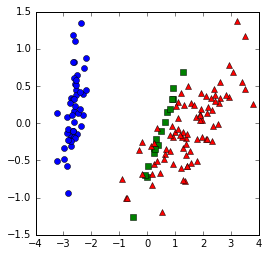

In [83]:
import sklearn.datasets
import sklearn.decomposition
tmean=np.array([[-3.59,0.25],[-1.09,-0.46],[0.75,1.07]])
pca = sklearn.decomposition.PCA(2)
data_pca = pca.fit_transform(data)
rmean,rcov,rprior=em(data_pca,3,0.001,mean=tmean)
print ("RESULTAT:")
print(rmean)
print(rcov)
print(rprior)
print(data_pca.size)
cluster=most_likely(data_pca,rmean,rcov,rprior)
plot_groups(data_pca,cluster,{0:'o',1:'s',2:'^'},figsize=(4,4))


In [73]:
a=np.array([[1,5],[2,1],[5,4],[8,2]])
em(a,2,0.01)


LinAlgError: singular matrix